In [2]:
import io
import requests

from PIL import Image as im

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [3]:
import pandas as pd

pdf = pd.read_parquet('../../ftransfer_ztf_2024-02-01_689626')


In [ ]:
pdf

In [4]:
Id = pdf['objectId'][1]

id_plus_repete = pdf['objectId'].value_counts().idxmax()

# We select data based on their shared ID, (here opting for the most frequently occurring alert).
pdf_selectionne = pdf.loc[pdf['objectId'] == id_plus_repete]



In [5]:
# Selecting the final alert ( if data is ordered).
pdf_selectionne = pdf_selectionne.iloc[-1]

In [6]:
pdf_selectionne['objectId']

'ZTF18adbmoft'

In [7]:
# do we need 'candidate' ? the actual value 
pdf_selectionne_cand = pdf_selectionne['prv_candidates'] 

In [8]:
liste_dicts = list(pdf_selectionne_cand)

df = pd.DataFrame(liste_dicts)

In [ ]:
df

In [ ]:
mjd = df['jd'].apply(lambda x: x - 2400000.5)
print(mjd[maskBadquality] )

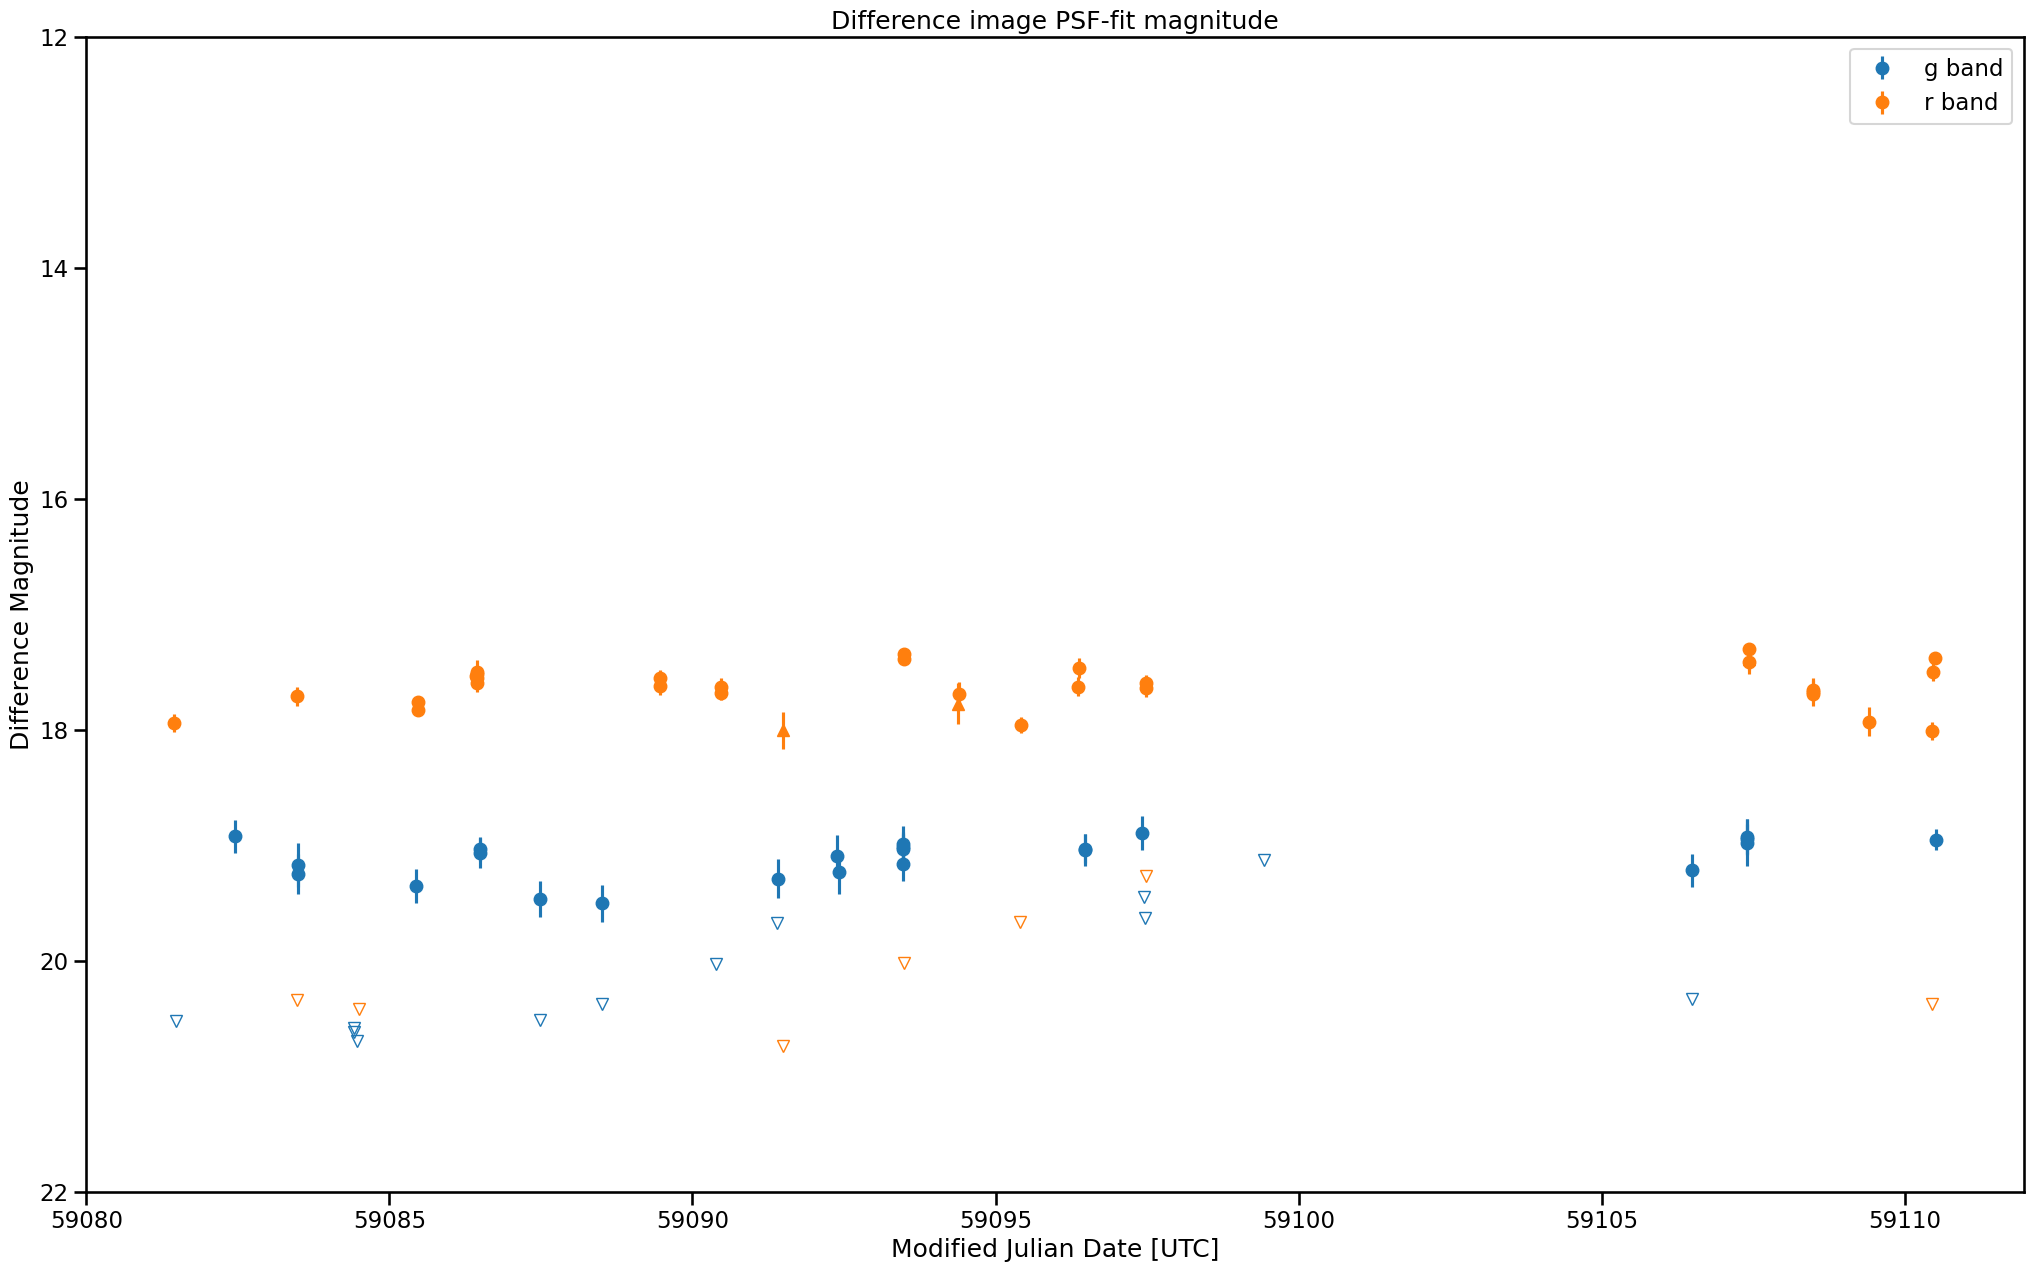

In [15]:

mjd = df['jd'].apply(lambda x: x - 2400000.5)

fig = plt.figure(figsize=(25, 15))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

# valid values 
maskValid = (df['rb'] > 0.55) & (df['nbad'] == 0)
# Upper limit values
maskUpper = pd.isna(df['magpsf'])
#bad quality values 
maskBadquality = ~maskValid & ~maskUpper


for filt in np.unique(df['fid']):
    maskFilt = df['fid'] == filt

    plt.errorbar(
        df[maskValid & maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df[maskValid & maskFilt]['magpsf'],
        df[maskValid & maskFilt]['sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )

    plt.plot(
        df[maskUpper & maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df[maskUpper & maskFilt]['diffmaglim'],
        ls='', marker='v', color=colordic[filt], markerfacecolor='none'
    )
    

    plt.errorbar(
        df[maskBadquality & maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df[maskBadquality & maskFilt]['magpsf'],
        df[maskBadquality & maskFilt]['sigmapsf'],
        ls='', marker='^', color=colordic[filt]
    )

plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');


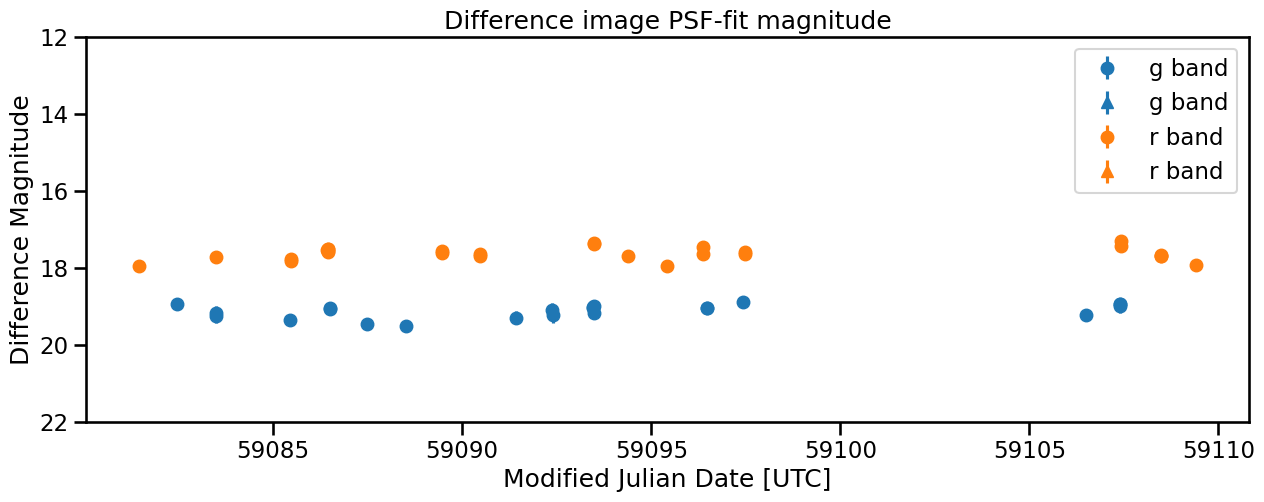

In [16]:

 

fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}
    
maskValid = (df['rb'] > 0.55) & (df['nbad'] == 0)

    
#t or 1 => candidate is from positive (sci minus ref) subtraction;
#f or 0 => candidate is from negative (ref minus sci) subtraction"
maskneg = (df['isdiffpos'] == 't') | (df['isdiffpos'] == 1)
maskpos = (df['isdiffpos'] == 'f') | (df['isdiffpos'] == 0)

for filt in np.unique(df['fid']):
    maskFilt = df['fid'] == filt

    # candidates from negative 

    plt.errorbar(
        df[maskValid & maskFilt & maskneg ]['jd'].apply(lambda x: x - 2400000.5),
        df[maskValid & maskFilt & maskneg ]['magpsf'],
        df[maskValid & maskFilt & maskneg ]['sigmapsf'],
        ls = '', marker='o', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )
    
    # candidates from positive 
    plt.errorbar(
        df[maskValid & maskFilt &  maskpos ]['jd'].apply(lambda x: x - 2400000.5),
        df[maskValid & maskFilt &  maskpos ]['magpsf'],
        df[maskValid & maskFilt &  maskpos ]['sigmapsf'],
        ls = '', marker='^', color=colordic[filt], label='{} band'.format(filtdic[filt])
    )
    

plt.ylim(12, 22)
plt.gca().invert_yaxis()
plt.legend()
plt.title('Difference image PSF-fit magnitude')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference Magnitude');



In [17]:
# from fink_science.conversion import dc_mag
from fink_utils.photometry.conversion import dc_mag
from fink_utils.photometry.utils import is_source_behind

# Take only valid measurements
maskValid = (df['rb'] > 0.55) & (df['nbad'] == 0)
df_valid = df[maskValid].sort_values('jd', ascending=False)

isSource = is_source_behind(
    df_valid['distnr'].values[0]
)

if isSource:
    print('It looks like there is a source behind. Lets compute the DC magnitude instead.')
    
    # Use DC magnitude instead of difference mag
    mag_dc, err_dc = np.transpose(
        [
            dc_mag(*args) for args in zip(
                df_valid['magpsf'].astype(float).values,
                df_valid['sigmapsf'].astype(float).values,
                df_valid['magnr'].astype(float).values,
                df_valid['sigmagnr'].astype(float).values,
                df_valid['isdiffpos'].values
            )
        ]
    )
    
    df_valid['mag_dc'] = mag_dc
    df_valid['err_dc'] = err_dc
else:
    print('No source found -- keeping PSF fit magnitude')
    df_valid['mag_dc'] = df_valid['magpsf']
    df_valid['err_dc'] = df_valid['sigmapsf']



It looks like there is a source behind. Lets compute the DC magnitude instead.


15.549999936421711 17.25617400459621


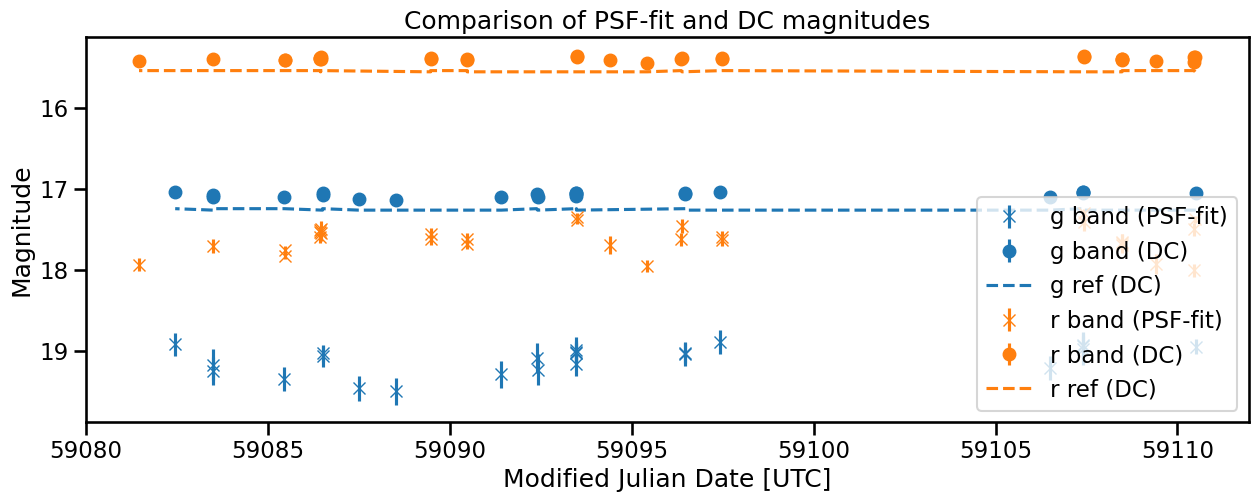

In [20]:
fig = plt.figure(figsize=(15, 5))

colordic = {1: 'C0', 2: 'C1'}
filtdic = {1: 'g', 2: 'r'}

for filt in np.unique(df_valid['fid']):
    maskFilt = df_valid['fid'] == filt

    plt.errorbar(
        df_valid[maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df_valid[maskFilt]['magpsf'],
        df_valid[maskFilt]['sigmapsf'],
        ls = '', marker='x', 
        color=colordic[filt], 
        label='{} band (PSF-fit)'.format(filtdic[filt]),
    )
    
    
    plt.errorbar(
        df_valid[maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df_valid[maskFilt]['mag_dc'],
        df_valid[maskFilt]['err_dc'],
        ls = '', marker='o', 
        color=colordic[filt], 
        label='{} band (DC)'.format(filtdic[filt]),
    )
    #To show if there is a variance in the reference
    plt.errorbar(
        df_valid[maskFilt]['jd'].apply(lambda x: x - 2400000.5),
        df_valid[maskFilt]['magnr'],
        ls = '--', 
        color=colordic[filt], 
        label='{} ref (DC)'.format(filtdic[filt]),
    )
    

ref_r = df_valid['magnr']*(df_valid['fid']==2)

ref_r = (ref_r[ref_r != 0]).mean()

ref_g = df_valid['magnr']*(df_valid['fid']==1)

ref_g = (ref_g[ref_g != 0]).mean()


print(ref_r, ref_g)
# c'est de valeurs moyennes mais sont -ils resonnables ? 
#plt.axhline(y=ref_r, color=colordic[2], linestyle='--')
#plt.axhline(y=ref_g, color=colordic[1], linestyle='--')
plt.gca().invert_yaxis()
plt.legend()
plt.title('Comparison of PSF-fit and DC magnitudes')
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Magnitude');

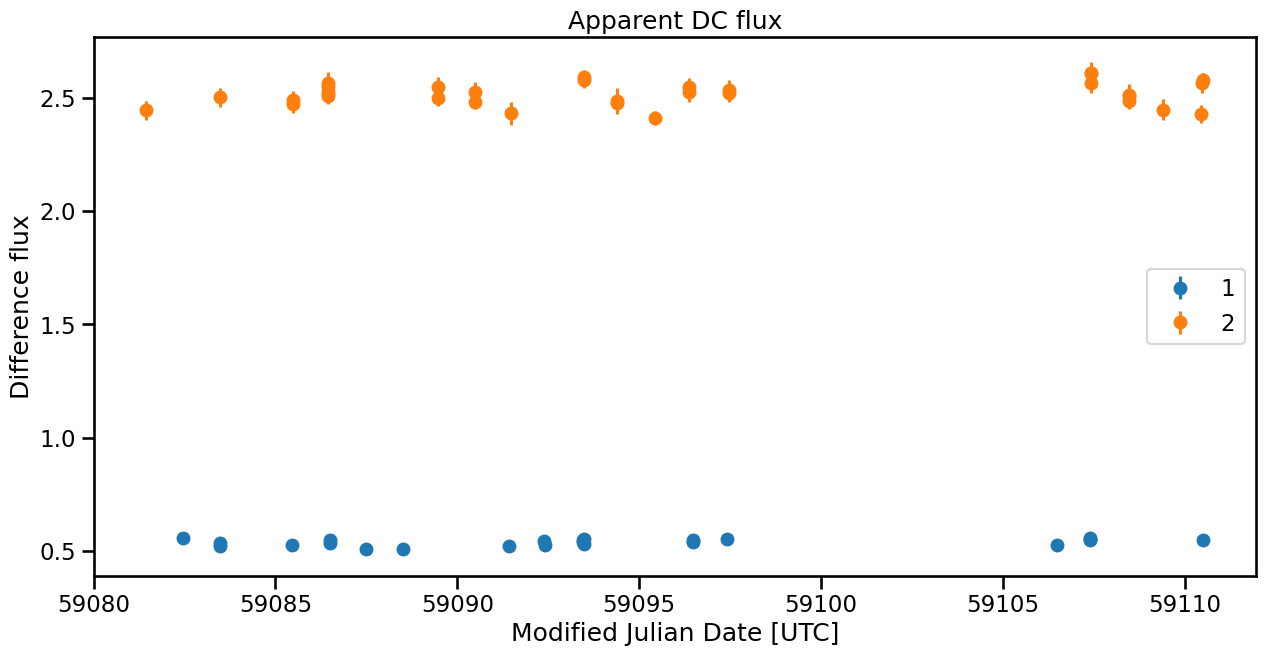

In [35]:
fig = plt.figure(figsize=(15, 7))

from fink_utils.photometry.conversion import apparent_flux


dc_flux, dc_sigflux = np.transpose(
        [
            apparent_flux(*args, jansky=True) for args in zip(
                df['magpsf'].astype(float).values,
                df['sigmapsf'].astype(float).values,
                df['magnr'].astype(float).values,
                df['sigmagnr'].astype(float).values,
                df['isdiffpos'].values
            )
        ]
)

df['dc_flux'] = dc_flux
df['dc_sigflux'] = dc_sigflux


for filt in np.unique(df['fid']):
    mask = df['fid'] == filt
    sub = df[mask]
    plt.errorbar(
        sub['jd'].apply(lambda x: x - 2400000.5),
        sub['dc_flux']*1e3,#*1e7/3, 
        sub['dc_sigflux']*1e3,#*1e7/3, 
        ls='', 
        marker='o',
        label=filt
    )
plt.legend()
plt.title('Apparent DC flux')# millijanksy !!! 
plt.xlabel('Modified Julian Date [UTC]')
plt.ylabel('Difference flux');


In [23]:
df[maskUpper]['dc_flux']

1    NaN
3    NaN
7    NaN
8    NaN
9    NaN
10   NaN
21   NaN
23   NaN
27   NaN
30   NaN
33   NaN
40   NaN
45   NaN
52   NaN
53   NaN
54   NaN
57   NaN
59   NaN
71   NaN
Name: dc_flux, dtype: float64

In [24]:
id_plus_repete

'ZTF18adbmoft'